In [258]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import os
import glob

from analytic_wfm.peakdetect import *

%run "Fonctions.ipynb"

In [2]:
final_df = pd.DataFrame()
files = find_all_extension('../Millau/Resultats/', '.txt')
for elt in files:
    final_df = pd.concat([final_df, recover_sig(elt, ['A07'])], axis=1)

In [3]:
test = []
for elt in final_df.columns:
    if 'time' in elt:
        test.append(elt)
        
final_df[test].isnull().sum()[final_df[test].isnull().sum() == 0].index[0]

'time_20170620143533742'

In [ ]:
2017-06-20-00-03-34-150
2017-06-20-00-03-41-144
2017-06-20-00-05-50-623
2017-06-20-00-05-57-142
2017-06-20-00-08-22-224
2017-06-20-00-33-07-871
2017-06-20-00-38-57-400
2017-06-20-00-39-22-968
2017-06-20-00-41-37-410
2017-06-20-00-45-20-611
2017-06-20-00-52-24-732
2017-06-20-00-54-50-955
2017-06-20-00-56-40-892
2017-06-20-00-57-12-093
2017-06-20-00-59-34-488

In [264]:
test = recover_sig('../Millau/Resultats/2017-06-20-hh-mm-ss/2017-06-20-00-mm-ss/2017-06-20-00-54-50-955.txt', ['A07', 'A09','A12'])

In [265]:
points1 = peakdetect(test.iloc[:, 1],test.iloc[:, 0], lookahead=5, delta=0.06)
points2 = peakdetect(test.iloc[:, 2],test.iloc[:, 0], lookahead=6, delta=0.069)
points3 = peakdetect(test.iloc[:, 3],test.iloc[:, 0], lookahead=6, delta=0.069)

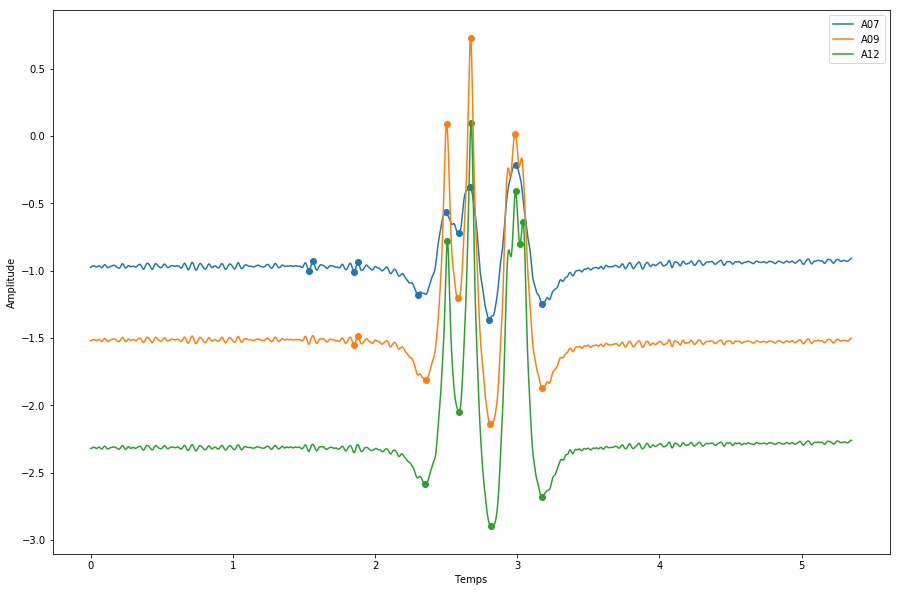

In [266]:
plt.figure(figsize=(15, 10))

# Courbe de capteurs
plt.plot(test.iloc[:,0], test.iloc[:, 1])
plt.plot(test.iloc[:,0], test.iloc[:, 2])
plt.plot(test.iloc[:,0], test.iloc[:, 3])

# Detections des maximas et minimas
plt.scatter(np.array(points1[0] + points1[1]).T[0], np.array(points1[0] + points1[1]).T[1])
plt.scatter(np.array(points2[0] + points2[1]).T[0], np.array(points2[0] + points2[1]).T[1])
plt.scatter(np.array(points3[0] + points3[1]).T[0], np.array(points3[0] + points3[1]).T[1])

plt.legend(['A07', 'A09','A12'])
plt.xlabel("Temps")
plt.ylabel("Amplitude")

plt.show()

#### Superposition des signaux

In [270]:
signaux = supperposition_signaux(test)
pics = calcul_pics(signaux, 6, 0.05, 0.15)

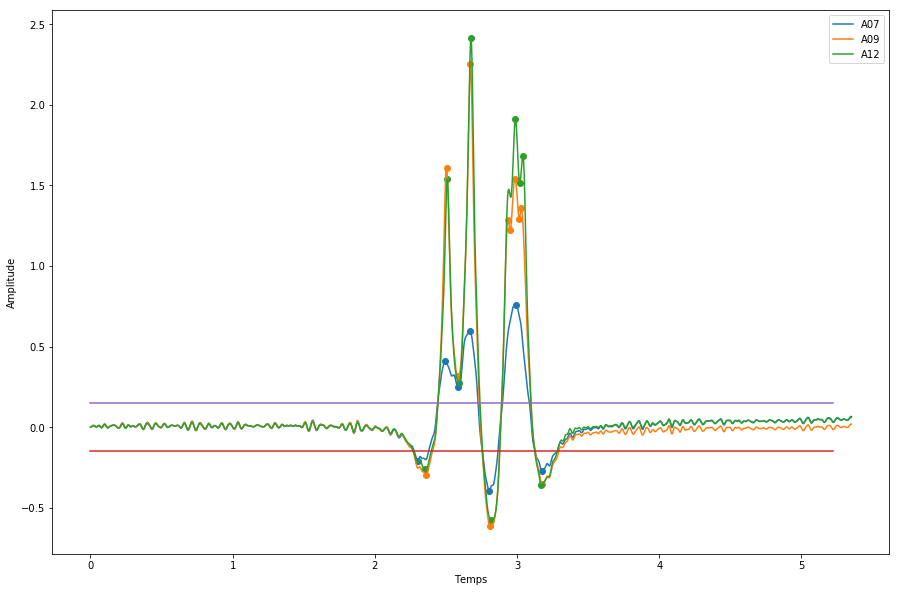

In [271]:
plt.figure(figsize=(15, 10))

# Courbe de capteurs
plt.plot(signaux.iloc[:,0], signaux.iloc[:, 1])
plt.plot(signaux.iloc[:,0], signaux.iloc[:, 2])
plt.plot(signaux.iloc[:,0], signaux.iloc[:, 3])

fourchette = 0.15
plt.plot([0, 5.22], [-fourchette, -fourchette])
plt.plot([0, 5.22], [fourchette, fourchette])

# Detections des maximas et minimas
for pic in pics:
    plt.scatter(pic[0], pic[1])

plt.legend(['A07', 'A09','A12'])
plt.xlabel("Temps")
plt.ylabel("Amplitude")

plt.show()

#### Selection meilleur signal

In [273]:
signaux = supperposition_signaux(test)
pics = calcul_pics(signaux, 6, 0.05, 0.15)
best = best_courbe(signaux, pics)

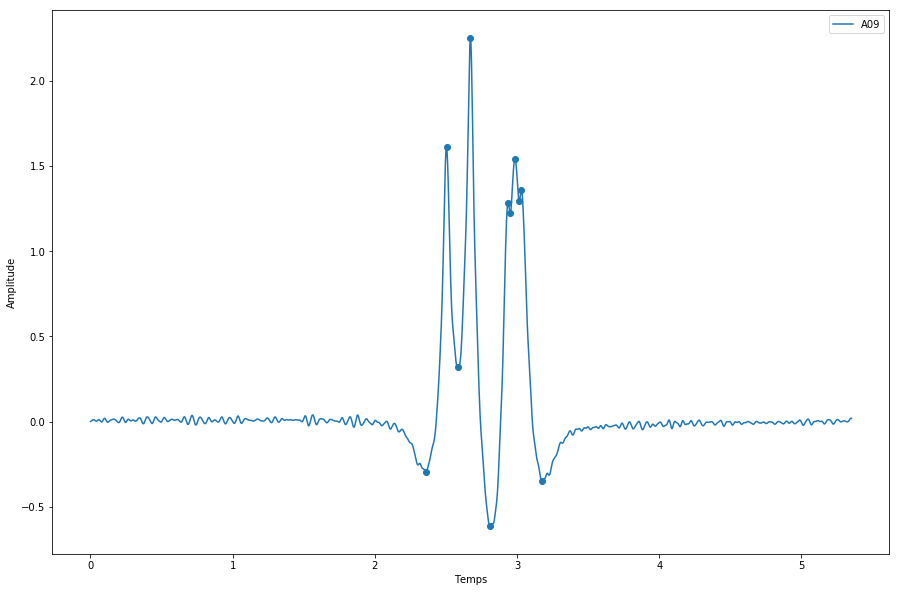

In [274]:
plt.figure(figsize=(15, 10))

# Courbe de capteurs
plt.plot(best[0].iloc[:, 0], best[0].iloc[:, 1])

# Detections des maximas et minimas
plt.scatter(best[1].iloc[:, 0], best[1].iloc[:, 1])

plt.legend([best[0].iloc[:,1].name])
plt.xlabel("Temps")
plt.ylabel("Amplitude")

plt.show()

#### Somme signaux

In [275]:
test3['time'] = test.iloc[:,0]
test3['sig'] = test.iloc[:,1] + test.iloc[:,2] + test.iloc[:,3]

In [276]:
points = peakdetect(test3.iloc[:, 1],test3.iloc[:, 0], lookahead=5, delta=0.04)

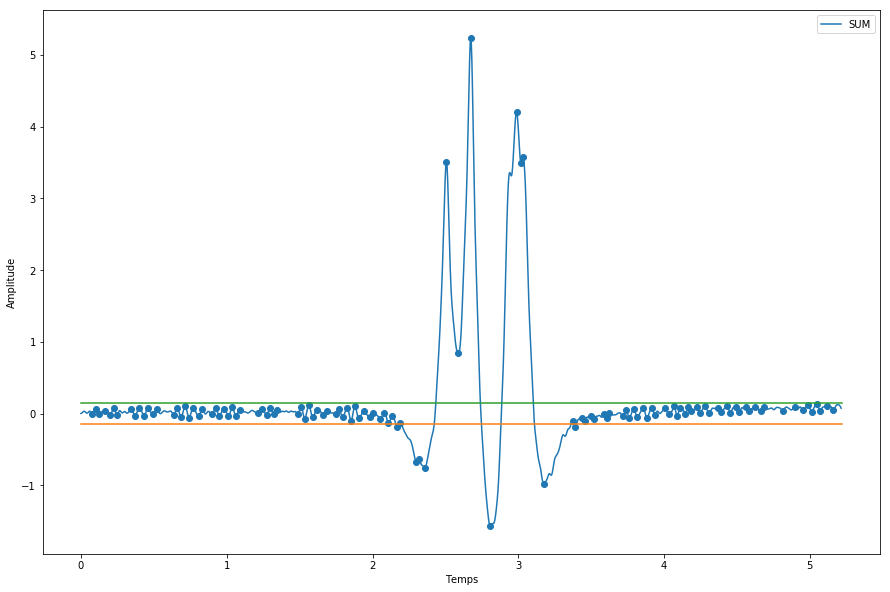

In [277]:
plt.figure(figsize=(15, 10))

# Courbe de capteurs
plt.plot(test3.iloc[:,0], test3.iloc[:, 1])

fourchette = 0.15
plt.plot([0, 5.22], [-fourchette, -fourchette])
plt.plot([0, 5.22], [fourchette, fourchette])

# Detections des maximas et minimas
plt.scatter(np.array(points[0] + points[1]).T[0], np.array(points[0] + points[1]).T[1])

plt.legend(['SUM'])
plt.xlabel("Temps")
plt.ylabel("Amplitude")

plt.show()